File open
First 100 positions in dictionary
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
{0.36}
+++++++++++++++++++++++++++++++++++
r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
{0.32}
+++++++++++++++++++++++++++++++++++
r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K B . R
{0.0}
+++++++++++++++++++++++++++++++++++
r . b q k b n r
p p . p p p p p
. . n . . . . .
. . p . . . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K B . R
{0.0}
+++++++++++++++++++++++++++++++++++
r . b q k b n r
p p . p p p p p
. . n . . . . .
. . p . . . . .
. . . P P . . .
. . . . . N . .
P P P . . P P P
R N B Q K B . R
{0.33}
+++++++++++++++++++++++++++++++++++
r . b q k b n r
p p . p p p p p
. . n . . . . .
. . . . . . . .
. . . p P . . .
. . . . . N . .
P P P .

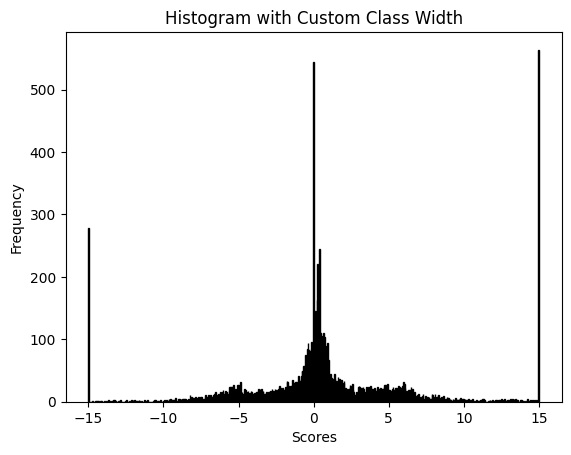

In [20]:
import chess
import chess.pgn
import io
import zstandard as zstd
import re
import numpy as np

number_of_games = 0
number_of_positions = 0
display_every = 1000
max_eval = -16
min_eval = 16
dic = {}
reparations = 0
with open('./data/lichess_db_standard_rated_2023-06.pgn.zst', 'rb') as f:
    dctx = zstd.ZstdDecompressor()
    reader = dctx.stream_reader(f)
    text_stream = io.TextIOWrapper(reader, encoding='utf-8')

    print("File open")

    class_width = 0.05
    bins = np.arange(-15, 15 + class_width, class_width)
    hist_values = np.zeros_like(bins[:-1])

    # Iterate over all games in the PGN file
    while True:
        game = chess.pgn.read_game(text_stream)
        if game is None:
            print("No game found!!!")
            break

        # Check if the game has embedded Stockfish evaluations
        has_evaluations = any('[%eval ' in node.comment for node in game.mainline())
        if not has_evaluations:
            #print("found game with no eval")
            continue

        # Iterate through all moves of the game
        board = chess.Board()         # Setup initial empty chess board
        scores = []
        for node in game.mainline():
            move = node.move
            board.push(move)
            # Get the comment (which contains the evaluation) for this move
            comment = node.comment
            match = re.search(r"\[%eval (.*?)\]", comment)
            if match is None:
                #print(f"did not find a match when one was expected.")
                continue
                
            score_str = match.group(1)
            
            # Convert mate in 'n' moves to large scores
            if '#' in score_str:
                if '-' in score_str:
                    score = -15 # <--- this should be -16
                else:
                    score = +15 # <--- this should be +16
            else:
                score = float(score_str)
                if score < -15:
                    score = -15
                elif score > 15:
                    score = 15
                    
            fen = board.fen()
            if fen in dic:
                dic[fen].add(score)
            else:
                dic[fen] = {score} 
                number_of_positions += 1
                
            scores.append(score)
            max_eval = max(score, max_eval)
            min_eval = min(score, min_eval)
                
        hist, _ = np.histogram(scores, bins=bins)
        hist_values += hist
    
        number_of_games += 1
        if number_of_games % display_every == 0:
            print(f"number_of_games: {number_of_games} number_of_positions: {number_of_positions} min_eval: {min_eval} max_eval: {max_eval}")

        if number_of_positions > 10000:
            n = 100
            print(f"First {n} positions in dictionary")
            i = 0
            for fen, scores in dic.items():
                i += 1
                if i > n:
                    break
                board = chess.Board()
                board.set_fen(fen)
                print(board)
                print(scores)
                print("+++++++++++++++++++++++++++++++++++")
            print("Positions with mutiple scores")
            for fen, scores in dic.items():
                if len(scores) > 1:
                    reparations += 1
                    board = chess.Board()
                    board.set_fen(fen)
                    print(board)
                    print(scores)
                    print("+++++++++++++++++++++++++++++++++++")
            print(f"reparations: {reparations}")
            break
    
import pandas as pd
import matplotlib.pyplot as plt
# Plot the histogram
plt.hist(bins[:-1], bins=bins, weights=hist_values, edgecolor='black')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Histogram with Custom Class Width')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define file path and class width
file_path = 'path/to/yourfile.csv'
class_width = 10

# Define the histogram bins (you can set the range according to your data)
bins = np.arange(0, 100 + class_width, class_width)
hist_values = np.zeros_like(bins[:-1])

# Read file in chunks and update the histogram
chunksize = 10**5  # Adjust this according to your available memory
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Assume the column you want to plot is named 'Value'
    values = chunk['Value']
    hist, _ = np.histogram(values, bins=bins)
    hist_values += hist

# Plot the histogram
plt.hist(bins[:-1], bins=bins, weights=hist_values, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Custom Class Width')
plt.show()